# Robustness Comparison of LIF and ParaLif
We fix the architecture, changing within it the neurons from *LIF* to *ParaLIF*. The architecture employed here is described in the baseline.

## Datasets

- MNIST
- CIFAR-10

In [1]:
import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

get_device()

device(type='mps')

# LIF Implementation
We call on the `trains` module to handle the spike train generation, this `train` module is designed to be differentiable allowing for gradient based adv. attacks.

In [2]:
import sys
import os

print(os.getcwd()) # WARNING: must be in **/biological-neurons/comparison for path append to work
sys.path.append("../trains")

from spikegen import rate

/Users/floriansuess/Documents/biological-neurons/comparison


In [3]:
import torch.nn as nn
import snntorch as snn
import hashlib
import json


def baseline(c, w, h, device='cpu'):
    hyper = {
        "decay_rate": 0.9,
        "observation_window": 4,
    }

    class SimpleSNN(nn.Module):
        torch.manual_seed(0) #  deterministic weight initials for perceptrons 
        def __init__(self, c, w, h):
            super(SimpleSNN, self).__init__()
            self.input_features = h * w * c
            
            self.fc1 = nn.Linear(self.input_features, 2**9)
            self.lif1 = snn.Leaky(
                beta=hyper["decay_rate"],
                spike_grad=snn.surrogate.atan()
            )
            self.fc2 = nn.Linear(2**9, 2**8)
            self.lif2 = snn.Leaky(
                beta=hyper["decay_rate"],
                spike_grad=snn.surrogate.atan()
            )
            self.fc3 = nn.Linear(2**8, 2**7)
            self.lif3 = snn.Leaky(
                beta=hyper["decay_rate"],
                spike_grad=snn.surrogate.atan()
            )

            self.fc4 = nn.Linear(2**7, 10)
            
            self.window = hyper["observation_window"]

        def forward(self, images):  # images (batch, colour_channel, height, width)
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()
            mem3 = self.lif3.init_leaky()
            
            flattened = images.view(images.size(0), -1)  # (batch, colour_channel*width*height)
            spike_train = rate(flattened, num_steps=self.window)
            output_spikes = []
            for step in range(self.window):
                x = self.fc1(spike_train[step])
                x, mem1 = self.lif1(x, mem1)
                
                x = self.fc2(x)
                x, mem2 = self.lif2(x, mem2)
                
                x = self.fc3(x)
                x, mem3 = self.lif3(x, mem3)

                x = self.fc4(x)
                output_spikes.append(x)
            return torch.stack(output_spikes, dim=0)

        def hash(self):
            id = json.dumps({
                "hyperparameters": hyper,
                "input_features": c*w*h,
            })
            return hashlib.md5(id.encode()).hexdigest()

    model = SimpleSNN(c, w, h)
    model.to(device)
    return model

# Running Evaluate and Train Methodology

In [4]:
def evaluate(model, loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        output_spikes = model(images)
        outputs = output_spikes.sum(dim=0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

def train(model, dataset, loader, epochs=10, device='cpu'):    
    torch.manual_seed(0) #  deterministic training
    logs = ""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    pre = evaluate(model, loader)
    logs += f'Accuracy before training: {pre:.2f}%\n'
    print(logs.strip())
    
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct_predictions = 0
        total_predictions = 0
    
        for images, labels in loader:
            output_spikes = model(images)
            outputs = output_spikes.sum(dim=0)
            loss = criterion(outputs, labels)  # forward pass
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
        epoch_loss = running_loss / len(loader)
        epoch_accuracy = (correct_predictions / total_predictions) * 100
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        epoch_log = f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%'
        logs += epoch_log + '\n'
        print(epoch_log)

# MNIST

In [17]:
from torchvision import datasets, transforms
from PIL import Image

batch_size = 2**6

transform = transforms.Compose([            
            transforms.Grayscale(),
            transforms.ToTensor()])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

def denormalize(tensor):
    tensor = tensor * 255
    array = tensor.cpu().numpy().astype(np.uint8)
    if tensor.ndim == 3 and tensor.shape[0] == 1:  # CxHxW to HxW if C == 1
        array = array.squeeze(0)  # Remove channel dimension for grayscale image
    return Image.fromarray(array, mode='L')

# Instantiate and Train LIF 

In [6]:
model = baseline(1, 28, 28)
train(model, "MNIST", train_loader)

Accuracy before training: 9.03%
Epoch [1/10], Loss: 2.3026, Accuracy: 11.10%
Epoch [2/10], Loss: 2.3017, Accuracy: 11.18%
Epoch [3/10], Loss: 2.2966, Accuracy: 12.36%
Epoch [4/10], Loss: 1.3671, Accuracy: 55.42%
Epoch [5/10], Loss: 0.4083, Accuracy: 88.07%
Epoch [6/10], Loss: 0.2850, Accuracy: 91.60%
Epoch [7/10], Loss: 0.2254, Accuracy: 93.25%
Epoch [8/10], Loss: 0.1861, Accuracy: 94.40%
Epoch [9/10], Loss: 0.1572, Accuracy: 95.28%
Epoch [10/10], Loss: 0.1378, Accuracy: 95.85%


# Evaluation (and taking a look at some misclassifications)
There are various metrics we can gather, but the cleanest is just the raw accuracy. But when comparing models, we will need to get a bit better here to prove statstically significant differences. Sometimes it's also good to just take a step back and actually look ourselves at the kinds of images the model was unable to classify to get some sort of potential guidance of how to proceed.

In [7]:
import numpy as np

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    output_spikes = model(images)
    outputs = output_spikes.sum(dim=0)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    
    misclassified = (predicted != labels).nonzero().squeeze()
    if misclassified.numel() == 0:
        continue
    if misclassified.dim() == 0:  # Make sure misclassified is always 1D
        misclassified = misclassified.unsqueeze(0)
        
    for i in misclassified:
        img = images[i]
        img = denormalize(img)
        misclassified_images.append(img)
        misclassified_labels.append(labels[i].item())
        misclassified_preds.append(predicted[i].item())

print(f'Accuracy of the network on the test images: {100 * correct / total}%')
print(f'-- note; failed to classify {len(misclassified_images)} image(s)')

Accuracy of the network on the test images: 95.44270833333333%
-- note; failed to classify 455 image(s)


# Taking a look at missclassifications

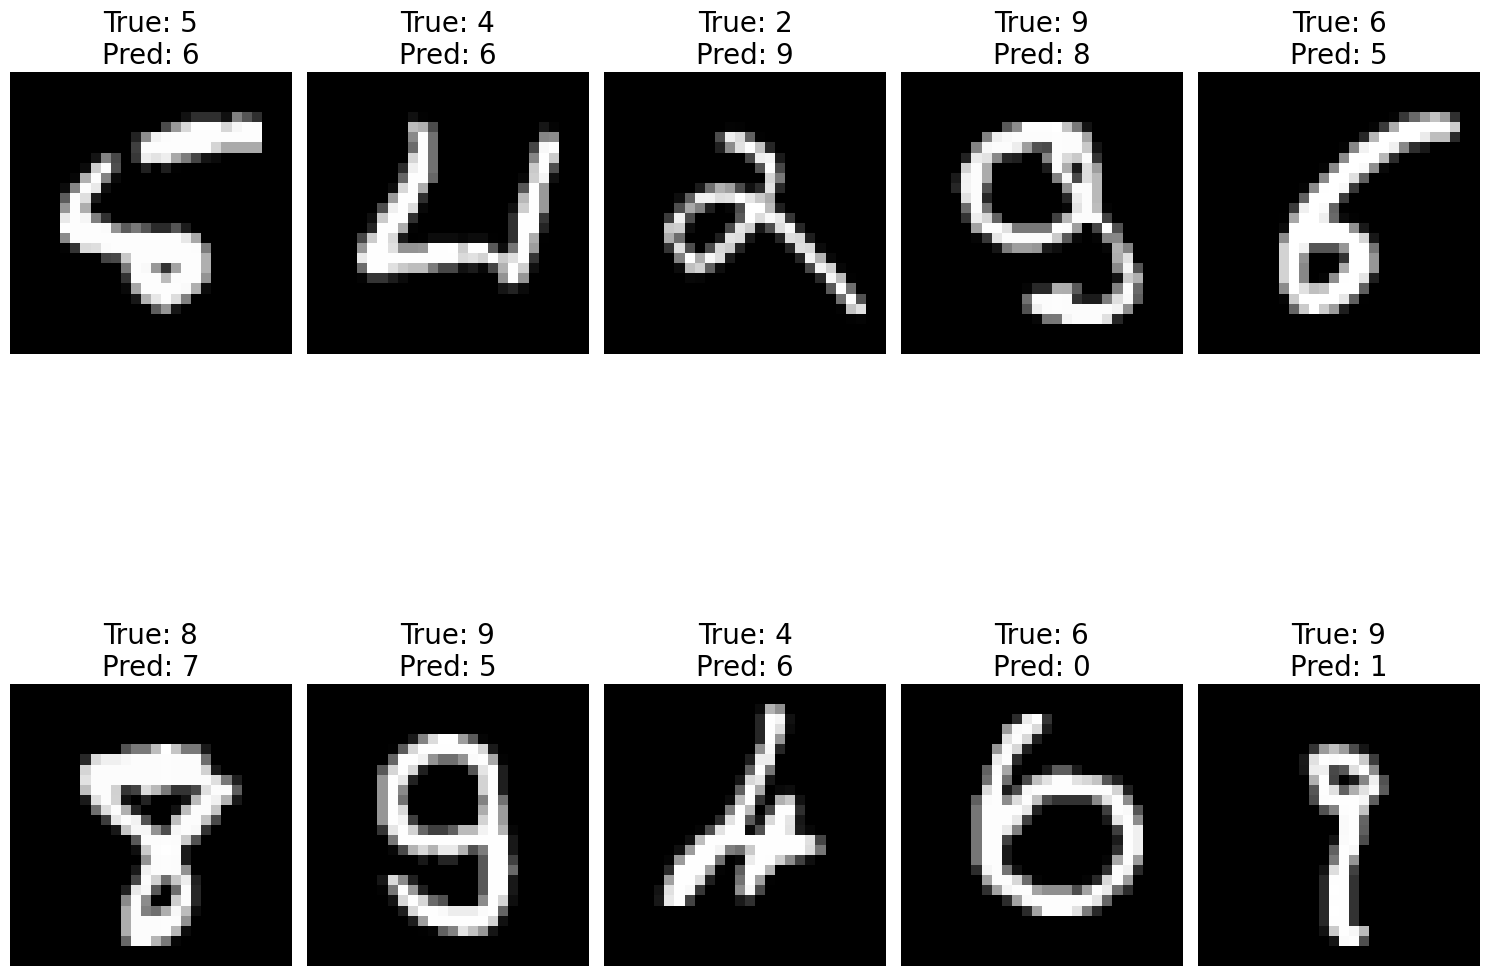

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(10):
    img, pred, label = misclassified_images[i], misclassified_preds[i], misclassified_labels[i]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"True: {label}\nPred: {pred}", fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Adveserial Attacks
A relatively new subject that highlights a models "robustness". Broadly speaking there are two classes of attacks;
- **"whitebox"** attacks: are specifically designed against a models implementation. It must know a models set of parameters/weights and the "white-box" term reflects that transparency.
- **"blackbox"** attacks: best contrasted against "whitebox" as being model agnostic. Techniques employed that are independent to the model implementation. Typically more preferred study due to their greater flexibility in everyday environments.

# Fast Gradient Sign Method (FGSM)
For a simple adversarial attack, we'll use the Fast Gradient Sign Method (FGSM), which is a common technique for generating adversarial examples. FGSM works by using the gradients of the neural network to create an adversarial example (hence "white-box". For an input image $x$, the adversarial example $x'$ is created as follows:

$$
x' = x + \epsilon \cdot sign(\nabla_x J(\theta, x, y))
$$

Where:
- $theta$: model parameters
- $J$: loss function
- $\epsilon$: small pertubation magnitude
- $\nabla_x J(\theta, x, y)$: gradient of the loss wrt. input image.

The idea is to take a small step in the direction of the gradient's sign, enough to mislead the model without significantly altering the perceptual quality of the image.

## My issue with $\epsilon$
It doesn't really give me much about how "different" the perturbed image is, hence I want to bound the FGSM attack by a [structural similarity index measure](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) (SSIM). It is a perception-based model that considers image degradation as perceived change in structural information.

We know the $\epsilon$ describes the size of the step to take for image degradation, so we can descent on this value until our perturbed image stays within our desired SSIM threshold.

In [23]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity

def fgsm_attack(model, loss, images, labels, eps):
    images.requires_grad = True # attach a gradient graph
    output_spikes = model(images)
    output = output_spikes.sum(dim=0)
    
    loss = loss(output, labels)
    
    model.zero_grad()
    loss.backward() # calculate gradients of model via backpropogating gradients

    data_grad = images.grad
    perturbed = images + eps * data_grad.sign()
    return perturbed.detach() # detached tensor from that gradient graph

ssim_threshold = 0.97

def ssim_bound_fgsm_attack(model, loss, original, labels):
    epsilon = 0.5 # starting epsilon huge

    def ssm(perturbed, original):
        old, new = denormalize(original.detach), denormalize(perturbed)
    
        # Convert PIL images to numpy arrays for SSIM computation
        old = np.array(old)
        new = np.array(new)

        data_range = 255  # Pixel intensity range for grayscale images
        similarity = structural_similarity(old, new, data_range=data_range)
        return similarity
    
    # def ssm(perturbed, original):
    #     old, new = denormalize(original.detach()), denormalize(perturbed)
        
    #     # scikit-image doesn't handle tensors, so move them to cpu and convert tensor to numpy
    #     old = old.cpu().numpy()
    #     new = new.cpu().numpy()

    #     # Ensure the data range is appropriate for SSIM
    #     data_range = np.max([new.max() - new.min(), old.max() - old.min()])
    #     similarity = [structural_similarity(o.squeeze(), p.squeeze(), data_range=data_range, win_size=11, channel_axis=None) for o, p in zip(old, new)]
    #     return np.mean(similarity)
    
    perturbed = fgsm_attack(model, loss, original, labels, epsilon)
    while ssm(perturbed, original) < ssim_threshold:
        epsilon *= 0.9
        perturbed = fgsm_attack(model, loss, original, labels, epsilon) 
    
    print(f'epsilon value of: {epsilon} satisfied SSIM threshold of: {ssim_threshold}')
    return perturbed

# Applying
We now want to capture those **instances of correctly classified images that have been perturbed in a way that causes a misclassification**.

In [24]:
misclassified_original_images = []
misclassified_perturbed_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()

correct_after_perturbation = 0
total = 0

criterion = nn.CrossEntropyLoss() # we want to maximise the CEL

for images, labels in test_loader:
    original = images.clone()
    perturbed = ssim_bound_fgsm_attack(model, criterion, images, labels)

    outputs_original = model(original)
    _, predicted_original = torch.max(outputs_original, 1)

    outputs_perturbed = model(perturbed)
    _, predicted_perturbed = torch.max(outputs_perturbed, 1)

    total += labels.size(0)
    correct_after_perturbation += (predicted_perturbed == labels).sum().item()
    
    correctly_classified_original = (predicted_original == labels)
    misclassified_after_perturbation = (predicted_perturbed != labels)
    truly_misclassified = correctly_classified_original & misclassified_after_perturbation
    
    for i in range(labels.size(0)):
        if truly_misclassified[i]:
            original_img = original[i]
            perturbed_img = perturbed[i]
            
            misclassified_original_images.append(denormalize(original_img))
            misclassified_perturbed_images.append(denormalize(perturbed_img))
            misclassified_labels.append(labels[i].item())
            misclassified_preds.append(predicted_perturbed[i].item())

print(f'Accuracy of the network on the perturbed test images: {100 * correct_after_perturbation / total}%')
# print(f'-- note; caused misclassification of {len(misclassified_perturbed_images)} additional image(s)')

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'int'

# Taking a look at advaserial missclassifications
We will display these as pixel intensities as heatmaps instead to use a range of colours to highlight how the perturbed image is different.

In [ ]:
def plot_images_with_diff(original_images, perturbed_images, labels, preds, n_images=5):
    plt.figure(figsize=(15, 15))  # Adjusted figure size to accommodate an additional row for differences
    
    n_images = min(n_images, len(original_images))
    for i in range(n_images):
        # Original
        plt.subplot(3, n_images, i + 1)
        img = original_images[i].permute(1, 2, 0).numpy()
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
        
        # Perturbed
        plt.subplot(3, n_images, n_images + i + 1)
        img = perturbed_images[i].permute(1, 2, 0).numpy()
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: {preds[i]}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_images_with_diff(torch.stack(misclassified_original_images), torch.stack(misclassified_perturbed_images), misclassified_labels, misclassified_preds)